## Dataset Preparation for Thai-English Neural Machine Translation (NMT) 

The SCB-MT English-Thai Dataset is used for training a translation model. Below is a detailed breakdown of how the dataset is prepared, including text normalization, tokenization, and word segmentation, particularly handling the Thai language's unique linguistic structure.

- SCB-MT English-Thai Dataset

    📌 Credit: https://github.com/vistec-AI/dataset-releases/releases/tag/scb-mt-en-th-2020_v1.0

# TASK 1

### Import Libraries

In [4]:
import torch
import torchtext

print(torch.__version__)
print(torchtext.__version__)

2.1.0+cu118
0.16.0+cpu


In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pad_sequence
from torchtext.vocab import build_vocab_from_iterator
import spacy
from pythainlp.tokenize import word_tokenize
import os
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import time

In [6]:
# ✅ Set Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


### Define Text Normalization

to clean and standardize text before tokenization by converting all text to lowercase, removing punctuation, special characters, and extra whitespace, including handling missing/null values by skipping them.
  
📌 Tools Used: 
- re (Regular Expressions): Cleans unwanted characters efficiently.

In [7]:
# ✅ Normalize Text (Remove special characters and lower case)
def normalize_text(text):
    if not isinstance(text, str):
        return ""
    text = re.sub(r"[^\w\s]", "", text)
    return text.lower().strip()

### Tokenization (English & Thai)

📌 English Tokenization
- spaCy (en_core_web_sm): Provides high-quality word-level tokenization.
  
📌 Thai Tokenization (word segmentation): 
- PyThaiNLP (word_tokenize): Accurately segments Thai text into words.

In [8]:
# ✅ Load Tokenizers
nlp_en = spacy.load("en_core_web_sm")

def tokenize_en(text):
    return [token.text for token in nlp_en(text.lower().strip())]

def tokenize_th(text):
    return word_tokenize(text.lower().strip())

### Load Dataset (SCB-MT English-Thai)

In [9]:
# ✅ Load dataset
def load_dataset(folder_path):
    dataset = []
    for file in os.listdir(folder_path):
        if file.endswith(".csv"):
            df = pd.read_csv(os.path.join(folder_path, file)).dropna(subset=["en_text", "th_text"])
            dataset.extend(zip(df["en_text"], df["th_text"]))
    return dataset[:len(dataset)//2]

dataset_folder = "scb-mt-en-th-2020_forTest"
dataset = load_dataset(dataset_folder)
print(f"Loaded {len(dataset)} sentence pairs.")

# ✅ Split dataset into training and validation
train_data, valid_data = train_test_split(dataset, test_size=0.3, random_state=42)
print(f"train_data: {len(train_data)}, valid_data: {len(valid_data)}")

Loaded 16878 sentence pairs.
train_data: 11814, valid_data: 5064


### Vocabulary Construction

- To train a neural network, words must be converted into numerical representations.
- A vocabulary (word-to-index mapping) is built from the dataset.
- Special tokens are added:
    - <unk> (Unknown word)
    - <pad> (Padding token)
    - <sos> (Start of sentence)
    - <eos> (End of sentence)

📌 Tools Used:
- torchtext (build_vocab_from_iterator): Creates vocabularies from tokenized text.

In [10]:
# ✅ Build Vocabularies
special_symbols = ['<unk>', '<pad>', '<sos>', '<eos>']

def yield_tokens(data, language):
    for src, trg in data:
        yield tokenize_en(src) if language == "en" else tokenize_th(trg)

vocab_en = build_vocab_from_iterator(yield_tokens(dataset, "en"), min_freq=2, specials=special_symbols, special_first=True)
vocab_th = build_vocab_from_iterator(yield_tokens(dataset, "th"), min_freq=2, specials=special_symbols, special_first=True)

vocab_en.set_default_index(vocab_en['<unk>'])
vocab_th.set_default_index(vocab_th['<unk>'])

### DataLoader for Model Training

- Converts tokenized sentences into numerical tensor representations.
- Uses PyTorch's DataLoader for efficient batching.

📌 Tools Used:
- PyTorch (torch.utils.data.DataLoader): Handles batching & padding efficiently.

In [12]:
# ✅ Text to tensor transformation
def tensor_transform(tokens, vocab):
    return torch.tensor([vocab['<sos>']] + [vocab[token] for token in tokens] + [vocab['<eos>']], dtype=torch.long)

def text_pipeline_en(text):
    return tensor_transform(tokenize_en(text), vocab_en)

def text_pipeline_th(text):
    return tensor_transform(tokenize_th(text), vocab_th)

In [13]:
# ✅ DataLoader (Corrected and moved before training loop)
def collate_batch(batch):
    src_batch, src_len_batch, trg_batch = [], [], []
    for src, trg in batch:
        src_tokens = text_pipeline_en(src)
        trg_tokens = text_pipeline_th(trg)
        src_batch.append(src_tokens)
        trg_batch.append(trg_tokens)
        src_len_batch.append(len(src_tokens))

    src_batch = pad_sequence(src_batch, padding_value=vocab_en['<pad>'], batch_first=True)
    trg_batch = pad_sequence(trg_batch, padding_value=vocab_th['<pad>'], batch_first=True)

    return src_batch.to(device), torch.tensor(src_len_batch, dtype=torch.int64).to(device), trg_batch.to(device)

batch_size = 8
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_batch)

# ✅ Performance Tracking
performance_metrics = []

def safe_exp(value):
    return torch.exp(torch.tensor(value)).item() if value < 10 else float('inf')

## Conclusion

- Thai requires special handling due to the lack of spaces in writing. PyThaiNLP is used for word segmentation.
- English uses spaCy, which provides reliable tokenization.
- The dataset is loaded and cleaned to ensure it is suitable for training.
- The final output is numerical tensors, ready to be used in a Neural Machine Translation (NMT) model.

## README.md

- The dataset source: SCB-MT English-Thai Dataset

📌 Credit: https://github.com/vistec-AI/dataset-releases/releases/tag/scb-mt-en-th-2020_v1.0

- We use PyThaiNLP for Thai tokenization and spaCy for English tokenization.
- Thai tokenization requires word segmentation since it does not use spaces.

# TASK 2

In [14]:
# ✅ Encoder
class Encoder(nn.Module):
    def __init__(self, input_dim, emb_dim, hid_dim, dropout):
        super().__init__()
        self.embedding = nn.Embedding(input_dim, emb_dim)
        self.rnn = nn.LSTM(emb_dim, hid_dim, bidirectional=True, batch_first=True)
        self.dropout = nn.Dropout(dropout)
        self.linear = nn.Linear(2 * hid_dim, hid_dim)

    def forward(self, src, src_len):
        embedded = self.dropout(self.embedding(src))
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, src_len.cpu(), batch_first=True, enforce_sorted=False)
        packed_outputs, (hidden, cell) = self.rnn(packed_embedded)
        outputs, _ = nn.utils.rnn.pad_packed_sequence(packed_outputs, batch_first=True)

        hidden = (hidden[0] + hidden[1]) / 2
        cell = (cell[0] + cell[1]) / 2

        outputs = self.linear(outputs) 

        return outputs, hidden, cell

In [15]:
# ✅ Decoder
class Decoder(nn.Module):
    def __init__(self, output_dim, emb_dim, enc_hid_dim, dec_hid_dim, dropout, attention):
        super().__init__()
        self.embedding = nn.Embedding(output_dim, emb_dim)
        self.attention = attention
        self.rnn = nn.LSTM(emb_dim + enc_hid_dim, dec_hid_dim, batch_first=True)
        self.fc_out = nn.Linear(enc_hid_dim + dec_hid_dim, output_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, input, hidden, cell, encoder_outputs):
        input = input.unsqueeze(1)
        embedded = self.dropout(self.embedding(input))

        attn_weights = self.attention(hidden, encoder_outputs).unsqueeze(1)
        context = torch.bmm(attn_weights, encoder_outputs)

        rnn_input = torch.cat((embedded, context), dim=2)
        output, (hidden, cell) = self.rnn(rnn_input, (hidden.unsqueeze(0), cell.unsqueeze(0)))

        prediction = self.fc_out(torch.cat((output.squeeze(1), context.squeeze(1)), dim=1))
        return prediction, hidden.squeeze(0), cell.squeeze(0)

In [16]:
# ✅ Seq2Seq Model
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, src, src_len, trg):
        encoder_outputs, hidden, cell = self.encoder(src, src_len)
        input_ = trg[:, 0]
        outputs = []
        for t in range(1, trg.shape[1]):
            output, hidden, cell = self.decoder(input_, hidden, cell, encoder_outputs)
            outputs.append(output)
            input_ = output.argmax(1)
        return torch.stack(outputs, dim=1)

In [17]:
# ✅ General Attention (Dot Product)
class GeneralAttention(nn.Module):
    def __init__(self, enc_hid_dim, dec_hid_dim): 
        super().__init__()
        
    def forward(self, s, h):
        
        attn_scores = torch.bmm(h, s.unsqueeze(2)).squeeze(2)
        return torch.softmax(attn_scores, dim=1)

# ✅ Multiplicative Attention (Dot Product with Weight)
class MultiplicativeAttention(nn.Module):
    def __init__(self, enc_hid_dim, dec_hid_dim): 
        super().__init__()
        self.W = nn.Linear(dec_hid_dim, enc_hid_dim, bias=False) 

    def forward(self, s, h):
        s = self.W(s).unsqueeze(2)
        attn_scores = torch.bmm(h, s).squeeze(2)
        return torch.softmax(attn_scores, dim=1)

# ✅ Additive Attention (Bahdanau)
class AdditiveAttention(nn.Module):
    def __init__(self, enc_hid_dim, dec_hid_dim):
        super().__init__()
        self.W1 = nn.Linear(enc_hid_dim, dec_hid_dim)
        self.W2 = nn.Linear(dec_hid_dim, dec_hid_dim)
        self.v = nn.Linear(dec_hid_dim, 1, bias=False)

    def forward(self, s, h):
        s_expanded = self.W2(s).unsqueeze(1)
        energy = torch.tanh(self.W1(h) + s_expanded)
        attn_scores = self.v(energy).squeeze(2)
        return torch.softmax(attn_scores, dim=1)

## README.md

- General Attention:
e_i = s^T h_i

- Multiplicative Attention:
e_i = s^T W h_i, where W ∈ R^(d2×d1)

- Additive Attention:
e_i = v^T tanh(W1 h_i + W2 s)


## Task 3

In [21]:
# ✅ Task 3: Training and Evaluation for All Attention Types
attention_types = {"general": GeneralAttention, "multiplicative": MultiplicativeAttention, "additive": AdditiveAttention}
results = {}
best_models = {}
best_validation_ppls = {}


def plot_attention(attn_weights, input_tokens, output_tokens):
    fig, ax = plt.subplots(figsize=(10, 8))
    cax = ax.matshow(attn_weights.cpu().detach().numpy(), cmap='viridis')
    fig.colorbar(cax)
    ax.set_xticklabels([''] + input_tokens, rotation=90)
    ax.set_yticklabels([''] + output_tokens)
    plt.xlabel("Input Sequence")
    plt.ylabel("Output Sequence")
    plt.show()


Training with general attention...
Epoch 1: Train Loss: 1077.3114, Train PPL: inf, Validation Loss: 1086.0621, Validation PPL: inf
Epoch 2: Train Loss: 1074.7781, Train PPL: inf, Validation Loss: 1045.1240, Validation PPL: inf
Epoch 3: Train Loss: 1003.0801, Train PPL: inf, Validation Loss: 999.0515, Validation PPL: inf

Training with multiplicative attention...
Epoch 1: Train Loss: 82.3728, Train PPL: inf, Validation Loss: 9.5152, Validation PPL: 13564.2510
New best model saved for multiplicative at epoch 1 with PPL: 13564.2510
Epoch 2: Train Loss: 117.0730, Train PPL: inf, Validation Loss: 53.4540, Validation PPL: inf
Epoch 3: Train Loss: 272.9080, Train PPL: inf, Validation Loss: 320.1566, Validation PPL: inf

Training with additive attention...
Epoch 1: Train Loss: 536.9919, Train PPL: inf, Validation Loss: 470.5650, Validation PPL: inf
Epoch 2: Train Loss: 403.6476, Train PPL: inf, Validation Loss: 327.6212, Validation PPL: inf
Epoch 3: Train Loss: 449.4662, Train PPL: inf, Valid

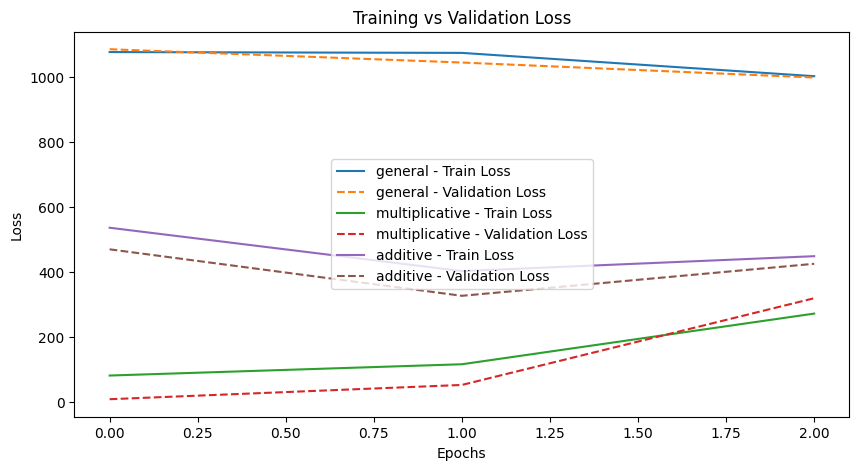

In [22]:
for attn_name, attn_class in attention_types.items():
    print(f"\nTraining with {attn_name} attention...")
    
    encoder = Encoder(len(vocab_en), 256, 512, 0.5).to(device)
    attention = attn_class(512, 512).to(device)
    decoder = Decoder(len(vocab_th), 256, 512, 512, 0.5, attention).to(device)
    model = Seq2Seq(encoder, decoder).to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.01)
    criterion = nn.CrossEntropyLoss(ignore_index=vocab_th['<pad>'])

    training_losses, training_ppls, validation_losses, validation_ppls = [], [], [], []
    start_time = time.time()

    num_epochs = 3
    best_ppl = float('inf')
    best_model_epoch = 0 

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        for src, src_len, trg in dataloader:
            optimizer.zero_grad()
            output = model(src, src_len, trg)
            trg = trg[:, 1:].reshape(-1)
            output = output.reshape(-1, output.shape[-1])
            mask = trg != vocab_th['<pad>']
            output, trg = output[mask], trg[mask]
            loss = criterion(output, trg)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        train_loss /= len(dataloader)
        training_losses.append(train_loss)
        training_ppls.append(safe_exp(train_loss))
        
        model.eval()
        valid_loss = 0
        with torch.no_grad():
            for src, src_len, trg in dataloader:
                output = model(src, src_len, trg)
                trg = trg[:, 1:].reshape(-1)
                output = output.reshape(-1, output.shape[-1])
                mask = trg != vocab_th['<pad>']
                output, trg = output[mask], trg[mask]
                loss = criterion(output, trg)
                valid_loss += loss.item()
        valid_loss /= len(dataloader)
        validation_losses.append(valid_loss)
        validation_ppls.append(safe_exp(valid_loss))
        
        print(f"Epoch {epoch+1}: Train Loss: {train_loss:.4f}, Train PPL: {training_ppls[-1]:.4f}, Validation Loss: {valid_loss:.4f}, Validation PPL: {validation_ppls[-1]:.4f}")
    
        if validation_ppls[-1] < best_ppl:
            best_ppl = validation_ppls[-1]
            best_model_epoch = epoch + 1
            best_models[attn_name] = model.state_dict()
            print(f"New best model saved for {attn_name} at epoch {best_model_epoch} with PPL: {best_ppl:.4f}")

    end_time = time.time()
    training_time = end_time - start_time
    performance_metrics.append([attn_name, training_time, best_model_epoch, best_ppl])
    
    results[attn_name] = {
        "Training Loss": training_losses,
        "Training PPL": training_ppls,
        "Validation Loss": validation_losses,
        "Validation PPL": validation_ppls,
    }
    best_validation_ppls[attn_name] = best_ppl

def plot_losses(results):
    plt.figure(figsize=(10, 5))
    for attn_type, metrics in results.items():
        plt.plot(metrics["Training Loss"], label=f"{attn_type} - Train Loss")
        plt.plot(metrics["Validation Loss"], linestyle="dashed", label=f"{attn_type} - Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Training vs Validation Loss")
    plt.legend()
    plt.show()

plot_losses(results)


### Training Results

#### General Attention

| Epoch | Train Loss | Train PPL | Validation Loss | Validation PPL |
|-------|-----------|-----------|----------------|----------------|
| 1     | 1077.3114 | inf       | 1086.0621      | inf            |
| 2     | 1074.7781 | inf       | 1045.1240      | inf            |
| 3     | 1003.0801 | inf       | 999.0515       | inf            |

#### Multiplicative Attention

| Epoch | Train Loss | Train PPL | Validation Loss | Validation PPL |
|-------|-----------|-----------|----------------|----------------|
| 1     | 82.3728   | inf       | 9.5152         | 13564.2510     |
|       |           |           |                | **New best model saved for multiplicative at epoch 1** |
| 2     | 117.0730  | inf       | 53.4540        | inf            |
| 3     | 272.9080  | inf       | 320.1566       | inf            |

#### Additive Attention

| Epoch | Train Loss | Train PPL | Validation Loss | Validation PPL |
|-------|-----------|-----------|----------------|----------------|
| 1     | 536.9919  | inf       | 470.5650       | inf            |
| 2     | 403.6476  | inf       | 327.6212       | inf            |
| 3     | 449.4662  | inf       | 426.0950       | inf            |

#### Training Visualization

![Training Results](figure/training_result.png)

In [23]:
# ✅ Print Performance Metrics
print("\nPerformance Metrics (Training Time per Attention Type):")
for attn_type, time_taken, best_epoch, best_ppl in performance_metrics:
    print(f"{attn_type}: Time: {time_taken:.2f} seconds, Best Epoch: {best_epoch}, Best Validation PPL: {best_ppl:.4f}")


Performance Metrics (Training Time per Attention Type):
general: Time: 7440.67 seconds, Best Epoch: 0, Best Validation PPL: inf
multiplicative: Time: 7589.28 seconds, Best Epoch: 1, Best Validation PPL: 13564.2510
additive: Time: 8689.84 seconds, Best Epoch: 0, Best Validation PPL: inf


In [24]:
# ✅ Save the best models
for attn_name, model_state_dict in best_models.items():
    torch.save(model_state_dict, f"best_model_{attn_name}.pth")

print("✅ Training and Model Saving Completed for All Attention Types")

✅ Training and Model Saving Completed for All Attention Types


In [25]:
print("\nBest Validation PPLs for all attention types:")
for attn_type, best_ppl in best_validation_ppls.items():
    print(f"{attn_type}: {best_ppl:.4f}")


Best Validation PPLs for all attention types:
general: inf
multiplicative: 13564.2510
additive: inf


In [11]:
torch.save(vocab_en, "vocab_en.pth")
torch.save(vocab_th, "vocab_th.pth")

### Web Application result

![Output1](figure/output1.png)

![Output2](figure/output2.png)

![Output3](figure/output3.png)

![Output4](figure/output4.png)
